# Portfolio Optimization using Monte Carlo

Please visit https://www.investopedia.com/articles/investing/112514/monte-carlo-simulation-basics.asp to learn about Monte Carlo and Portfolio Optimization

Importing the necessary packages and setting up visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import quandl
%matplotlib inline
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

Importing the 2016-2019 Apple, Hewlett-Packard, Intel and Microsoft stock prices from https://www.quandl.com/. Quandl provides quality financial, economic and alternative data for, among other things, research and commercial use

In [3]:
quandl.ApiConfig.api_key = 'insert quandl key here'
#The number of stocks and the ticker symbols can be modified to get a variety of different portfolios
stocks = ['AAPL','HPQ','INTC','MSFT']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2019-12-31' }, paginate=True)

Glancing at the imported data to get a sense of what we are dealing with here

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 3 columns):
date         2242 non-null datetime64[ns]
ticker       2242 non-null object
adj_close    2242 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 52.7+ KB


,date,ticker,adj_close
None,,,
0,2018-03-27,MSFT,89.47
1,2018-03-26,MSFT,93.78
2,2018-03-23,MSFT,87.18
3,2018-03-22,MSFT,89.79
4,2018-03-21,MSFT,92.48


Reconfiguring the dataframe to make it easier to use


In [5]:
def revised_df(dataframe):
    df = dataframe.set_index('date')
    df = df.pivot(columns='ticker')
    df.columns = list(column[1] for column in df.columns)
    return df

In [6]:
table = revised_df(data)
table.head()

,AAPL,HPQ,INTC,MSFT
date,,,,
2016-01-04,101.783763,10.933558,31.810946,52.181598
2016-01-05,99.233131,11.037239,31.661204,52.419653
2016-01-06,97.291172,10.641368,30.959285,51.467434
2016-01-07,93.185040,10.151243,29.798780,49.677262
2016-01-08,93.677776,9.972159,29.489936,49.829617


Visualizing the time series

In [7]:
def plot_timeseries(dataframe):
    plt.figure(figsize=(15, 8))
    for val in dataframe.columns.values:
        plt.plot(dataframe.index, dataframe[val], alpha=1.0, lw=3, label=val)
    plt.ylabel('Price ($)')
    plt.xlabel('Time (YYYY-MM)')
    plt.legend(loc='upper left', fontsize=18)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


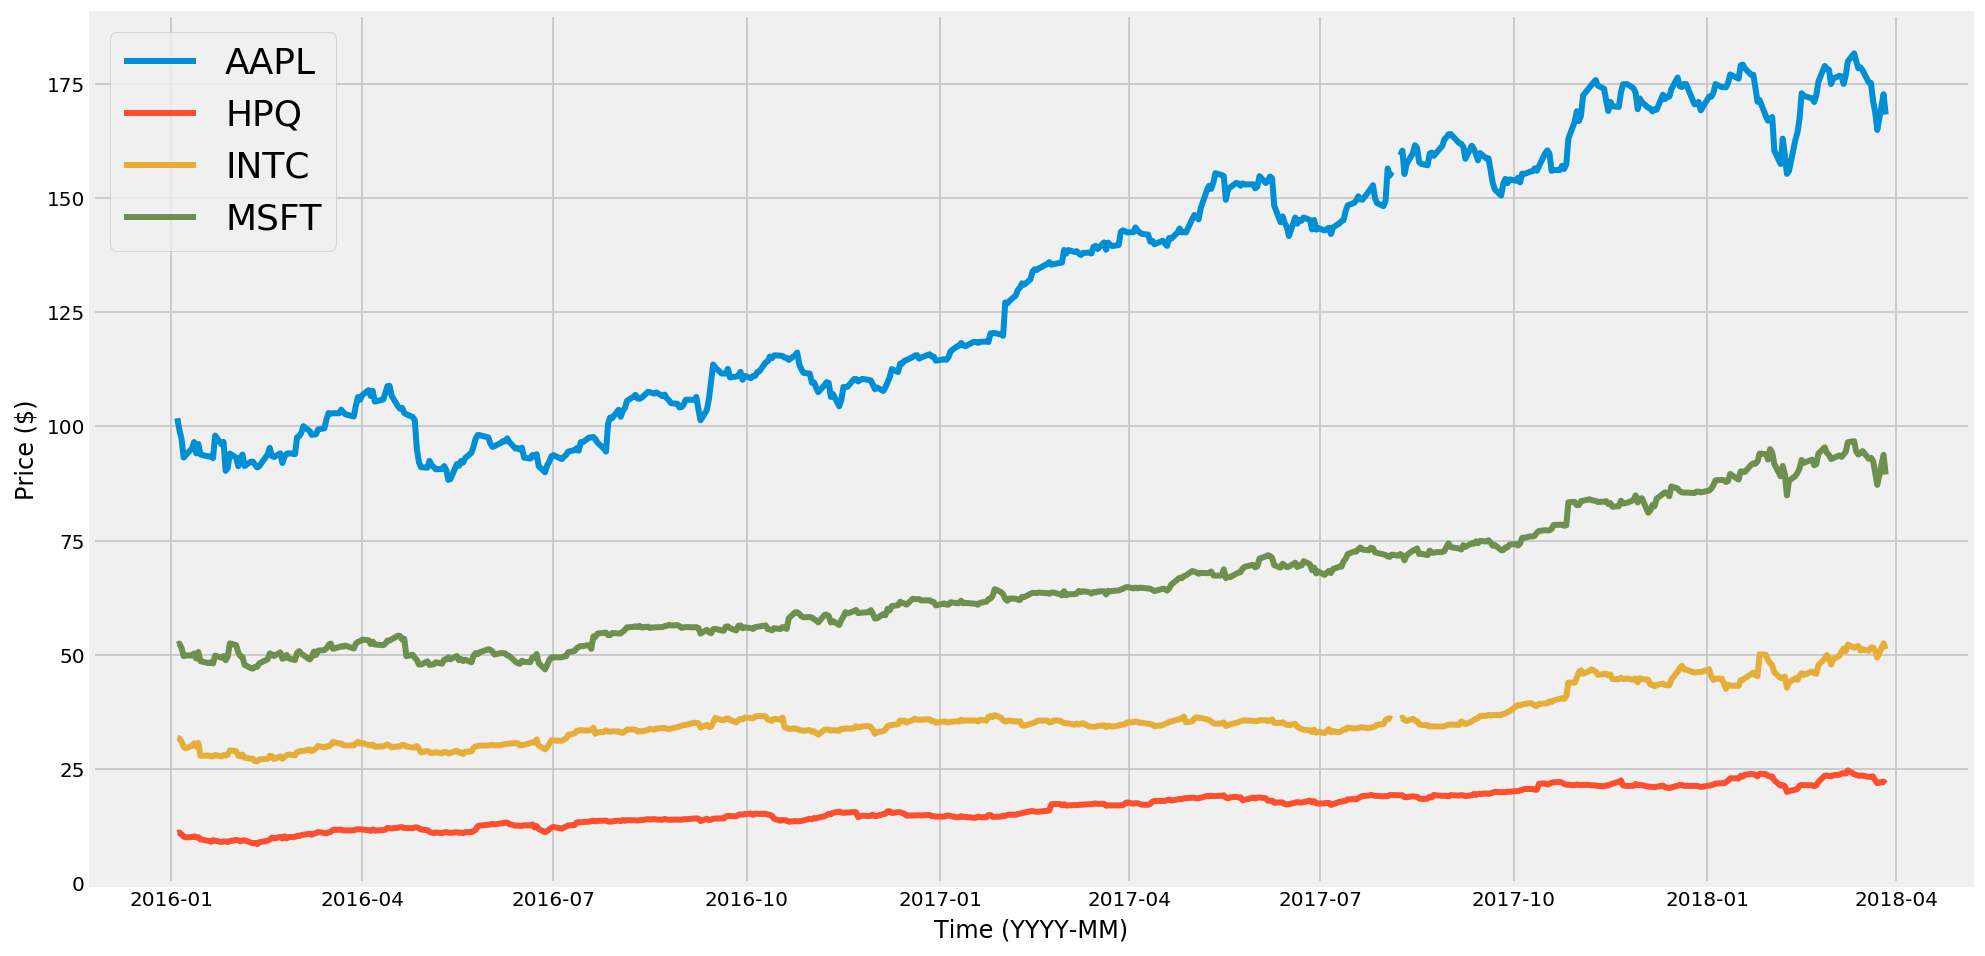

In [8]:
plot_timeseries(table)

The first step in the optimization process is to generate a large number of portfolios with random weights 

In [9]:
#Annualised returns
def portfolio_corrected_returns(weights, mean_returns, cov):
    returns = np.sum(mean_returns*weights)*252 #There are 252 trading days in a year
    stdev = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))*np.sqrt(252)
    return returns, stdev
  
def random_generation(num_portfolios, num_stocks, mean_returns, cov, risk_free_rate):
    weights_collection = []
    results = np.zeros((3,num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_stocks) #The complexity grows with the number of stocks
        weights /= np.sum(weights)
        weights_collection.append(weights)
        portfolio_return, portfolio_stdev = portfolio_corrected_returns(weights, mean_returns, cov)
        results[0,i] = portfolio_stdev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stdev #Sharpe ratio
    return weights_collection, results

The following function locates interesting portfolios within the set of randomly generated ones

In [10]:
def volatility_sharpe(num_portfolios, num_stocks, mean_returns, cov, risk_free_rate):
    weights, results = random_generation(num_portfolios, num_stocks, mean_returns, cov, risk_free_rate)
    
    max_sharpe_index = np.argmax(results[2]) #index of the max sharpe value
    stdev_max_sharpe = results[0,max_sharpe_index] #stdev that corresponds to the max sharpe 
    result_max_sharpe = results[1,max_sharpe_index] #return that corresponds to the max sharpe
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_index],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_index = np.argmin(results[0]) #index of the min volatility
    stdev_min_vol = results[0,min_vol_index] #stdev that corresponds to the min volatility
    result_min_vol = results[1,min_vol_index] #return that corresponds to the min volatility
    min_vol_allocation = pd.DataFrame(weights[min_vol_index],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(result_max_sharpe,2))
    print("Annualised Volatility:", round(stdev_max_sharpe,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(result_min_vol,2))
    print("Annualised Volatility:", round(stdev_min_vol,2))
    print("\n")
    print(min_vol_allocation)
    
    return results, stdev_max_sharpe, result_max_sharpe, stdev_min_vol, result_min_vol

Calculating the maximum sharpe ratio and minimum volatility

In [13]:
num_portfolios = 27000 #The bigger the number, the better is the random nature of the results
num_stocks = len(table.columns)
returns = table.pct_change()
mean_returns = returns.mean()
cov = returns.cov()
risk_free_rate = 0.0152 #The 52-week US treasury bill rate at the start of 2020
results, stdev_max_sharpe, result_max_sharpe, stdev_min_vol, result_min_vol = volatility_sharpe(num_portfolios, num_stocks, mean_returns, cov, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.18


             AAPL    HPQ  INTC   MSFT
allocation  30.02  35.96  1.57  32.44
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.27
Annualised Volatility: 0.17


             AAPL    HPQ   INTC   MSFT
allocation  36.25  15.09  18.08  30.57


Let's plot the annualised returns vs annualised volatility

In [14]:
def visualize(results, stdev_max_sharpe, result_max_sharpe, stdev_min_vol, result_min_vol):
    
    plt.figure(figsize=(13, 8))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.5)
    plt.colorbar()
    plt.scatter(stdev_max_sharpe,result_max_sharpe,marker='D',color='k',s=500, label='Maximum Sharpe ratio')
    plt.scatter(stdev_min_vol,result_min_vol,marker='D',color='r',s=500, label='Minimum volatility')
    plt.title('Portfolio Optimization based on Monte Carlo')
    plt.xlabel('Annualised volatility')
    plt.ylabel('Annualised returns')
    plt.legend(loc='upper left', labelspacing=1.0)

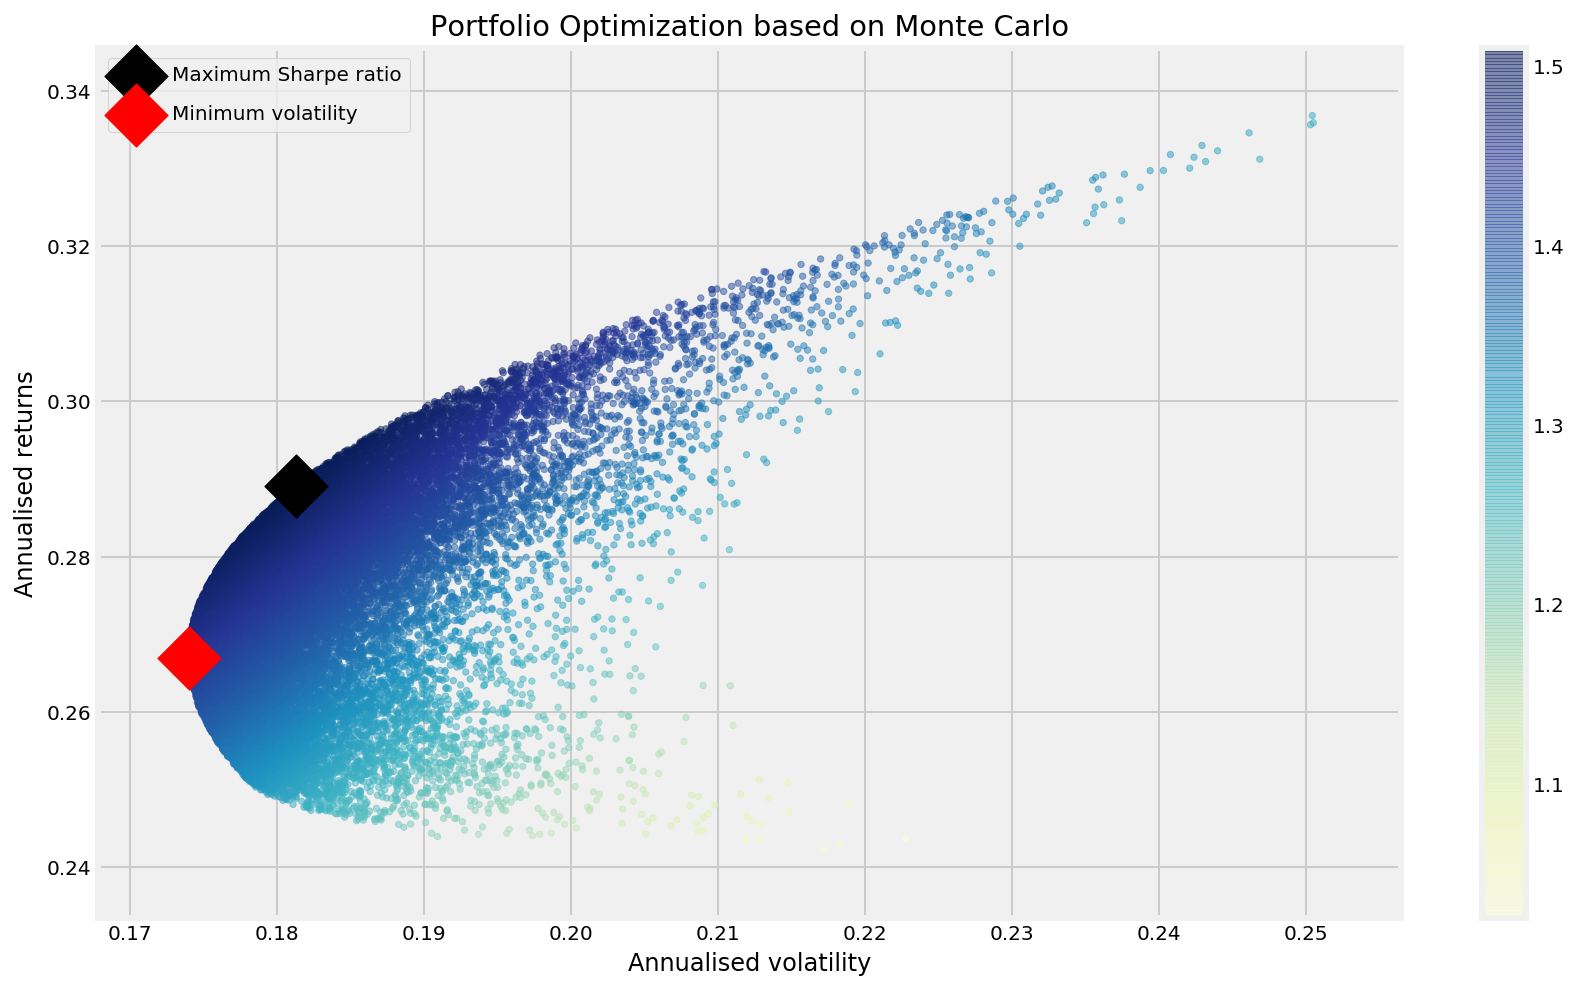

In [15]:
visualize(results, stdev_max_sharpe, result_max_sharpe, stdev_min_vol, result_min_vol)

Feel free to experiment with the code